In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
cd /content/drive/MyDrive/ED_Prediction_Fairness_Benchmark-

/content/drive/MyDrive/ED_Prediction_Fairness_Benchmark-


In [39]:
cd Benchmark_scripts/

/content/drive/MyDrive/ED_Prediction_Fairness_Benchmark-/Benchmark_scripts


In [40]:
import sys
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')
# append original data path helpers.py
sys.path.append('/content/drive/My Drive/MIMIC_IV_ED')

from helpers import PlotROCCurve

df_train = pd.read_csv('/content/drive/My Drive/MIMIC_IV_ED/train_with_outcomes.csv')
df_test = pd.read_csv('/content/drive/My Drive/MIMIC_IV_ED/test_with_outcomes.csv')
confidence_interval = 95
random_seed=0

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
random.seed(random_seed)
np.random.seed(random_seed)

In [41]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_death,before_ed_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS,outcome_sepsis,outcome_copd_exac,outcome_acs_mi,outcome_stroke,outcome_ards,outcome_aki,outcome_pe,outcome_pneumonia_bacterial,outcome_pneumonia_viral,outcome_pneumonia_all,outcome_asthma_acute_exac,outcome_ahf,outcome_copd_asthma
0,215414,18566742,27103162.0,38538786,2135-07-16 16:08:00,2135-07-17 01:49:00,58,F,2132,NaN,2135-07-17 00:20:00,2135-07-18 18:20:00,NaN,HISPANIC/LATINO,2135-07-16 16:08:00,2135-07-17 01:49:00,Other,2135,61,False,False,False,0 days 09:41:00,NaN,NaN,False,True,False,0,0,0,2136-07-30 17:08:00,379 days 15:19:00,False,0,0,0,0,0,0,9.68,NaN,379.64,37.166667,93.0,16.0,100.0,160.0,66.0,4.167576,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.760621,78.220568,17.260731,98.141378,127.427849,73.556876,2.127651,5.0,2.0,97.333333,2,4,3,1,1,1,False,False,False,False,False,False,False,False,False,False,False,False,False
1,205452,16853729,NaN,30043998,2178-01-25 05:09:00,2178-01-25 07:05:00,91,F,2169,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,2178,100,False,False,False,0 days 01:56:00,NaN,NaN,False,False,False,0,1,7,2178-03-11 09:43:00,45 days 02:38:00,False,0,0,5,0,0,0,1.93,NaN,45.11,36.666667,76.0,20.0,95.0,165.0,95.0,4.167576,...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,36.777778,75.000000,18.000000,97.000000,133.000000,80.000000,2.127651,2.0,3.0,118.333333,7,9,8,1,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,200705,16026698,NaN,39475313,2128-10-19 20:01:00,2128-10-19 20:16:00,23,M,2128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2128,23,False,False,False,0 days 00:15:00,NaN,NaN,False,False,False,0,0,1,2129-01-05 21:12:00,78 days 00:56:00,False,0,0,0,0,0,0,0.25,NaN,78.04,37.222222,125.0,22.0,99.0,156.0,96.0,7.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.833333,95.000000,18.000000,100.000000,143.000000,82.000000,7.000000,1.0,1.0,116.000000,0,12,4,4,4,4,False,False,False,False,False,False,False,False,False,False,False,False,False
3,87038,15398519,25237915.0,35495155,2147-06-15 09:50:00,2147-06-15 15:55:00,57,M,2136,NaN,2147-06-15 14:00:00,2147-06-16 16:45:00,NaN,BLACK/AFRICAN AMERICAN,2147-06-15 09:50:00,2147-06-15 15:55:00,Medicare,2147,68,False,False,False,0 days 06:05:00,NaN,NaN,False,True,False,0,2,5,2147-07-01 10:46:00,15 days 18:51:00,False,0,2,5,0,0,1,6.08,NaN,15.79,37.166667,110.0,22.0,92.0,122.0,89.0,7.000000,...,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,36.777778,106.000000,20.000000,92.000000,96.000000,75.000000,0.000000,7.0,10.0,100.000000,12,16,7,5,3,3,False,True,False,False,False,False,False,False,False,False,False,False,True
4,373626,16787687,23674090.0,31087259,2181-03-20 10:38:00,2181-03-21 12:55:00,87,F,2176,NaN,2181-03-20 22:01:00,2181-03-21 12:55:00,NaN,BLACK/AFRICAN AMERICAN,2181-03-20 10:38:00,2181-03-21 12:55:00,Medicare,2181,92,False,False,False,1 days 02:17:00,NaN,NaN,False,True,False,0,0,2,2181-04-06 09:43:00,15 days 20:48:00,False,0,0,2,0,0,0,26.28,NaN,15.87,37.111111,9

In [42]:
print('training size =', len(df_train), ', testing size =', len(df_test))

training size = 359043 , testing size = 89761


In [43]:
variable = ["age", "gender",

            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d",
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d",

            "triage_temperature", "triage_heartrate", "triage_resprate",
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",

            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough",
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",

            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia",
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1",
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2",
            "cci_Cancer2", "cci_HIV",

            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy",
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_ards"


In [44]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [ ]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [45]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [46]:
result_list = []

Logistic Regression (with standardization):
AUC: 0.8245055089313928
AUPRC: 0.007363992319222806
Sensitivity: 0.78125
Specificity: 0.6840796297328946
Score thresold: 0.0006513941643885234
2.5 97.5


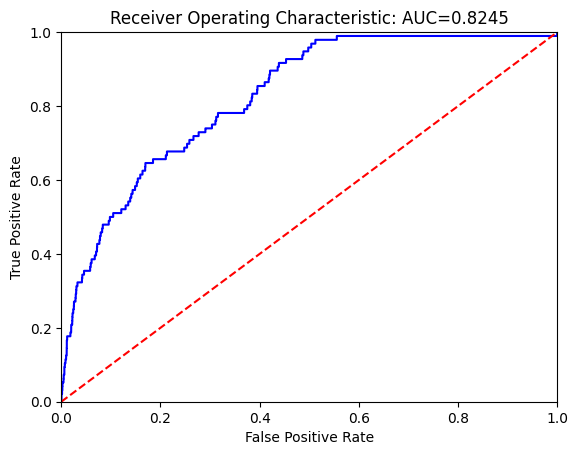

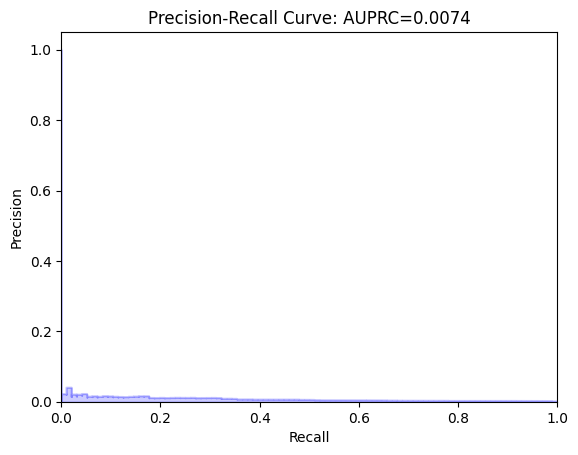

Accuracy: 0.7852965096199909


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pickle
import time

# Step 1: 定义需要标准化的变量
vars_to_standardize = [
    "age", "n_ed_30d", "n_ed_90d", "n_ed_365d",
    "n_hosp_30d", "n_hosp_90d", "n_hosp_365d",
    "n_icu_30d", "n_icu_90d", "n_icu_365d",
    "triage_temperature", "triage_heartrate",
    "triage_resprate", "triage_o2sat",
    "triage_sbp", "triage_dbp", "triage_pain"
]

# Step 2: 标准化训练集与测试集
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[vars_to_standardize] = scaler.fit_transform(X_train[vars_to_standardize])
X_test_scaled[vars_to_standardize] = scaler.transform(X_test[vars_to_standardize])

# Step 3: 模型训练
print("Logistic Regression (with standardization):")
logreg = LogisticRegression(random_state=random_seed, max_iter=1000)
start = time.time()
logreg.fit(X_train_scaled, y_train)
runtime = time.time() - start

# Step 4: 模型保存
with open('task1_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)

# Step 5: 模型预测 + 评估
probs = logreg.predict_proba(X_test_scaled)
y_pred = (probs[:, 1] >= 0.001).astype(int)

result = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed)
# 计算 Accuracy
acc = accuracy_score(y_test, y_pred)

results = ["LR"]
results.extend(result)
results.append(runtime)
results.append(acc)

print("Accuracy:", acc)


In [13]:
result_list = [results]

result_df = pd.DataFrame(result_list, columns=[
    'Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold',
    'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap',
    'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity',
    'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime', 'accuracy'
])

result_df = result_df.round(3)

formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df['Accuracy'] = result_df['accuracy']

formatted_result_df


,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime,Accuracy
0,LR,0.001,0.825 (0.784-0.855),0.007 (0.005-0.013),0.781 (0.695-0.792),0.684 (0.682-0.823),2.651,0.997


In [47]:
!pip install fairlearn

In [48]:
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
from sklearn.utils import resample
import numpy as np
import pandas as pd

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else np.nan

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else np.nan

def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp) if (fn + tp) > 0 else np.nan

def bootstrap_fairness_metric_ci(df, y_true_col, y_pred_col, y_score_col, group_col, B=1000, random_seed=42):
    group_vals = df[group_col].unique()

    metric_funcs = {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1': f1_score,
        'specificity': specificity_score,
        'fpr': false_positive_rate,
        'fnr': false_negative_rate,
        'selection_rate': selection_rate
    }

    results = {metric: {g: [] for g in group_vals} for metric in metric_funcs}
    results['auc'] = {g: [] for g in group_vals}

    for b in range(B):
        sample = resample(df, replace=True, random_state=random_seed + b)

        mf = MetricFrame(
            metrics=metric_funcs,
            y_true=sample[y_true_col],
            y_pred=sample[y_pred_col],
            sensitive_features=sample[group_col]
        )

        for metric in metric_funcs:
            for g in group_vals:
                results[metric][g].append(mf.by_group[metric][g])

        for g in group_vals:
            mask = sample[group_col] == g
            auc_val = roc_auc_score(sample.loc[mask, y_true_col], sample.loc[mask, y_score_col])
            results['auc'][g].append(auc_val)

    rows = []
    for metric in results:
        for g in group_vals:
            values = results[metric][g]
            rows.append({
                'Metric': metric,
                'Group': g,
                'Mean': np.mean(values),
                'CI_lower': np.percentile(values, 2.5),
                'CI_upper': np.percentile(values, 97.5)
            })

    return pd.DataFrame(rows)

In [17]:
# Clean gender variable
gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

# Apply mask to target and predictions
y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
y_score_gender = probs[:, 1][valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

# Create dataframe for bootstrap function
fair_df = pd.DataFrame({
    'y_true': y_test_gender,
    'y_pred': y_pred_gender,
    'y_score': y_score_gender,
    'gender': gender_grouped
})

# Run bootstrapped fairness metric CI
ci_df_gender = bootstrap_fairness_metric_ci(
    df=fair_df,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='gender',
    B=1000,
    random_seed=42
)

# Print formatted output
print("\n=== Logistic Regression Per-Gender Metrics for ARDS (Mean + 95% CI) ===")
for group in ['Female', 'Male']:
    group_id = 0 if group == 'Female' else 1
    group_metrics = ci_df_gender[ci_df_gender['Group'] == group_id]
    print(f"\n{group}:")
    for _, row in group_metrics.iterrows():
        metric = row['Metric']
        mean = row['Mean']
        ci_low = row['CI_lower']
        ci_high = row['CI_upper']
        print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")


=== Logistic Regression Per-Gender Metrics for ARDS (Mean + 95% CI) ===

Female:
accuracy         Mean = 0.81208, CI = (0.80878, 0.81556)
precision        Mean = 0.00307, CI = (0.00198, 0.00439)
recall           Mean = 0.61013, CI = (0.46546, 0.75000)
f1               Mean = 0.00611, CI = (0.00394, 0.00871)
specificity      Mean = 0.81227, CI = (0.80899, 0.81576)
fpr              Mean = 0.18773, CI = (0.18424, 0.19101)
fnr              Mean = 0.38987, CI = (0.25000, 0.53454)
selection_rate   Mean = 0.18813, CI = (0.18463, 0.19137)
auc              Mean = 0.82577, CI = (0.77983, 0.86839)

Male:
accuracy         Mean = 0.75383, CI = (0.74967, 0.75765)
precision        Mean = 0.00365, CI = (0.00259, 0.00487)
recall           Mean = 0.74038, CI = (0.61534, 0.86667)
f1               Mean = 0.00727, CI = (0.00515, 0.00967)
specificity      Mean = 0.75385, CI = (0.74974, 0.75757)
fpr              Mean = 0.24615, CI = (0.24243, 0.25026)
fnr              Mean = 0.25962, CI = (0.13333, 0.38466)

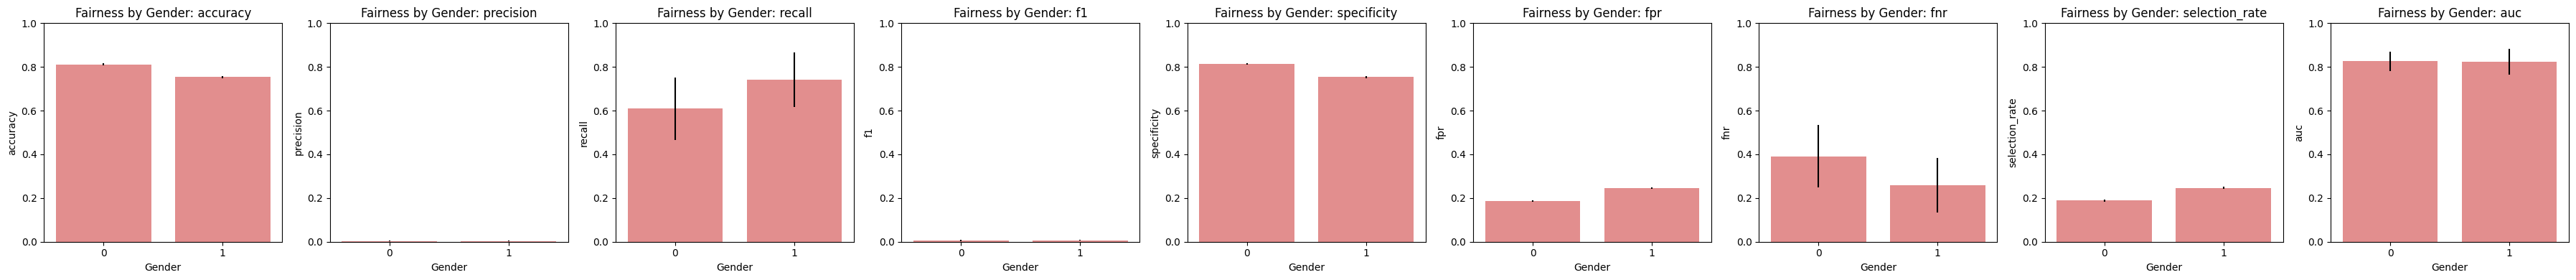

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

ci_df_gender['Error Lower'] = ci_df_gender['Mean'] - ci_df_gender['CI_lower']
ci_df_gender['Error Upper'] = ci_df_gender['CI_upper'] - ci_df_gender['Mean']

metrics = ci_df_gender['Metric'].unique()
n_metrics = len(metrics)

# Plot setup
fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_gender[ci_df_gender['Metric'] == metric]

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='lightcoral'
    )
    ax.set_title(f'Fairness by Gender: {metric}')
    ax.set_xlabel('Gender')
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


/tmp/ipython-input-19-242715977.py:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linestyle='--')


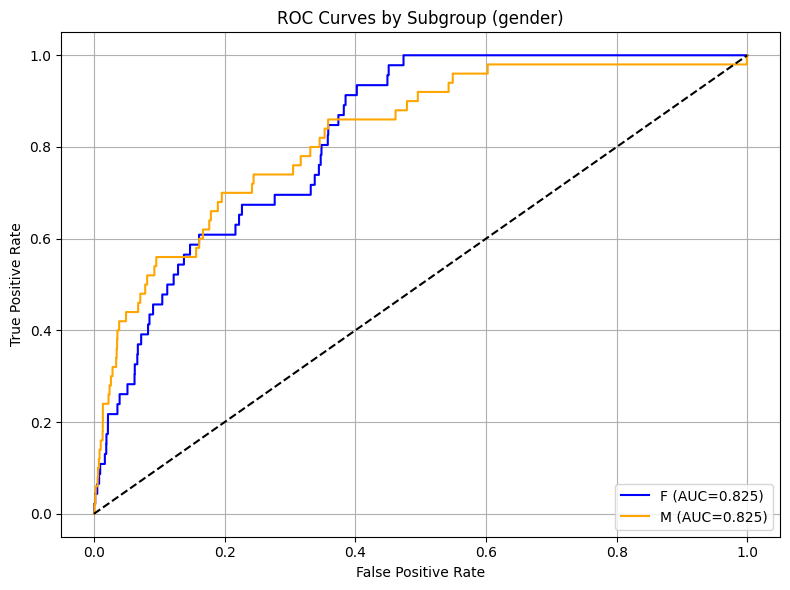

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Split by gender
female_df = fair_df[fair_df['gender'] == 0]  # Female
male_df = fair_df[fair_df['gender'] == 1]    # Male

# Calculate ROC curve points and AUC
fpr_f, tpr_f, _ = roc_curve(female_df['y_true'], female_df['y_score'])
auc_f = roc_auc_score(female_df['y_true'], female_df['y_score'])

fpr_m, tpr_m, _ = roc_curve(male_df['y_true'], male_df['y_score'])
auc_m = roc_auc_score(male_df['y_true'], male_df['y_score'])

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_f, tpr_f, label=f'F (AUC={auc_f:.3f})', color='blue')
plt.plot(fpr_m, tpr_m, label=f'M (AUC={auc_m:.3f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', linestyle='--')

plt.title('ROC Curves by Subgroup (gender)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
# Clean and validate ethnicity
ethnicity_raw = df_test['ethnicity'].astype(str)
valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw.str.strip() != '') &
    (~ethnicity_raw.str.lower().isin(['unknown', 'unable to obtain']))
)

# Apply mask to target and predictions
y_test_ethnicity = y_test[valid_mask]
y_pred_ethnicity = y_pred[valid_mask]
y_score_ethnicity = probs[:, 1][valid_mask]
ethnicity_clean = ethnicity_raw[valid_mask].str.strip().str.lower()

# Step 3: Map ethnicity into grouped labels
ethnicity_grouped = ethnicity_clean.map({
    'white': 'White',
    'black/african american': 'Black or African American',
    'asian': 'Asian',
    'hispanic/latino': 'Hispanic/Latino',
    'other': 'Other'
}).fillna('Other')

fair_df_ethnicity = pd.DataFrame({
    'y_true': y_test_ethnicity,
    'y_pred': y_pred_ethnicity,
    'y_score': y_score_ethnicity,
    'ethnicity': ethnicity_grouped
})

# Run bootstrapped fairness metric CI
ci_df_ethnicity = bootstrap_fairness_metric_ci(
    df=fair_df_ethnicity,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='ethnicity',
    B=1000,
    random_seed=42
)

print("\n=== Logistic Regression Per-Ethnicity Metrics for ARDS (Mean + 95% CI) ===")
for group in sorted(ci_df_ethnicity['Group'].unique()):
    group_metrics = ci_df_ethnicity[ci_df_ethnicity['Group'] == group]
    print(f"\n{group}:")
    for _, row in group_metrics.iterrows():
        metric = row['Metric']
        mean = row['Mean']
        ci_low = row['CI_lower']
        ci_high = row['CI_upper']
        print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local


=== Logistic Regression Per-Ethnicity Metrics for ARDS (Mean + 95% CI) ===

Asian:
accuracy         Mean = 0.72065, CI = (0.70021, 0.74031)
precision        Mean = 0.00363, CI = (0.00000, 0.00958)
recall           Mean = 0.85200, CI = (0.00000, 1.00000)
f1               Mean = 0.00721, CI = (0.00000, 0.01898)
specificity      Mean = 0.72036, CI = (0.70010, 0.73992)
fpr              Mean = 0.27964, CI = (0.26008, 0.29990)
fnr              Mean = nan, CI = (nan, nan)
selection_rate   Mean = 0.28037, CI = (0.26122, 0.30063)
auc              Mean = nan, CI = (nan, nan)

Black or African American:
accuracy         Mean = 0.76977, CI = (0.76273, 0.77692)
precision        Mean = 0.00274, CI = (0.00102, 0.00479)
recall           Mean = 0.66969, CI = (0.38462, 0.93333)
f1               Mean = 0.00545, CI = (0.00203, 0.00952)
specificity      Mean = 0.76986, CI = (0.76266, 0.77692)
fpr              Mean = 0.23014, CI = (0.22308, 0.23734)
fnr              Mean = 0.33031, CI = (0.06667, 0.61538)


In [21]:
fair_df_ethnicity['ethnicity'].value_counts()


,count
ethnicity,
White,35865
Other,33497
Black or African American,12923
Hispanic/Latino,4546
Asian,1923


In [22]:
fair_df_ethnicity.groupby(['ethnicity', 'y_true']).size()


ethnicity                  y_true
Asian                      False      1921
                           True          2
Black or African American  False     12911
                           True         12
Hispanic/Latino            False      4542
                           True          4
Other                      False     33494
                           True          3
White                      False     35800
                           True         65
dtype: int64

/tmp/ipython-input-23-1104984648.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/tmp/ipython-input-23-1104984648.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/tmp/ipython-input-23-1104984648.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/tmp/ipython-input-23-1104984648.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/tmp/ipython-input-23-1104984648.py:28: UserWarning: set

ValueError: 'yerr' (shape: (2, 5)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (2,))

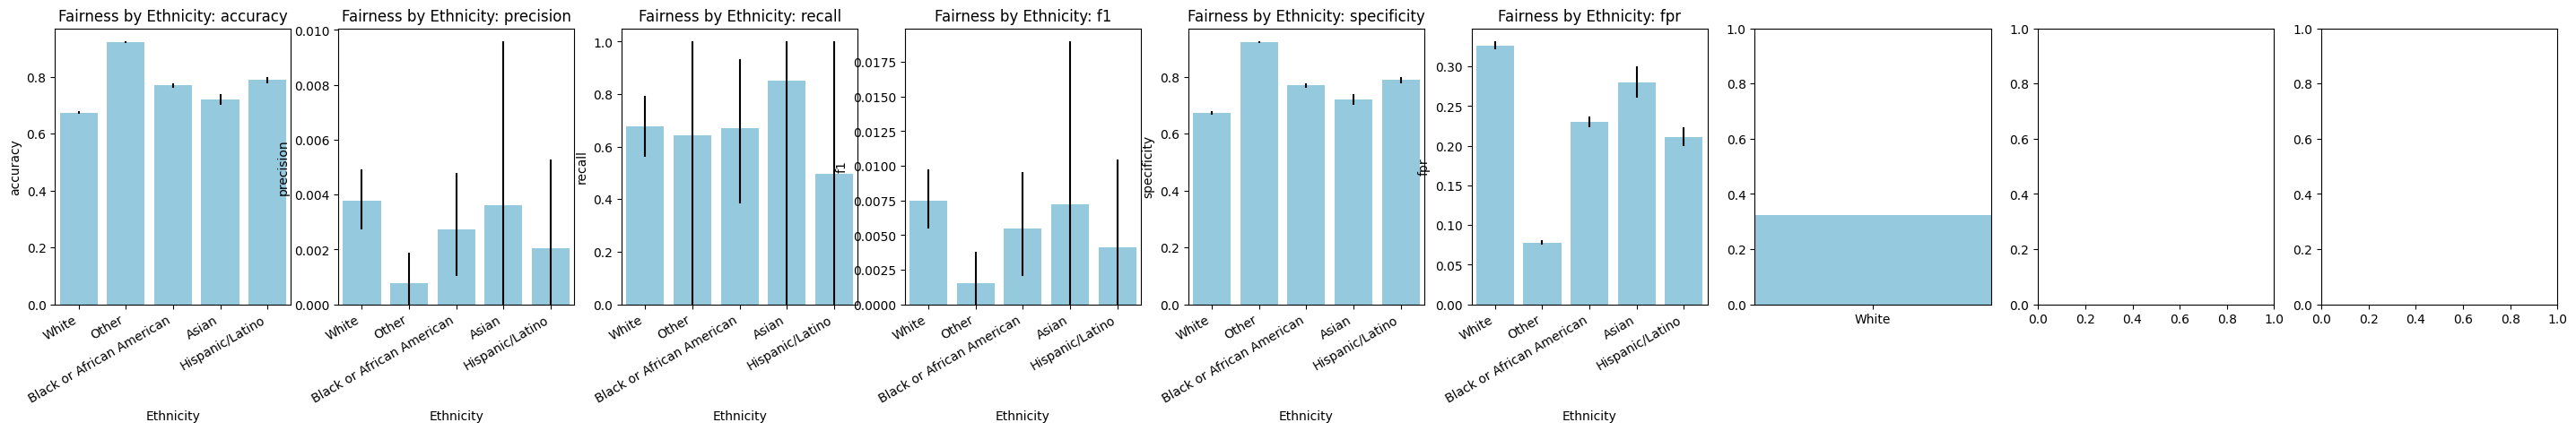

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

ci_df_ethnicity['Error Lower'] = ci_df_ethnicity['Mean'] - ci_df_ethnicity['CI_lower']
ci_df_ethnicity['Error Upper'] = ci_df_ethnicity['CI_upper'] - ci_df_ethnicity['Mean']

metrics = ci_df_ethnicity['Metric'].unique()
n_metrics = len(metrics)

fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_ethnicity[ci_df_ethnicity['Metric'] == metric]

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='skyblue'
    )
    ax.set_title(f'Fairness by Ethnicity: {metric}')
    ax.set_xlabel('Ethnicity')
    ax.set_ylabel(metric)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()

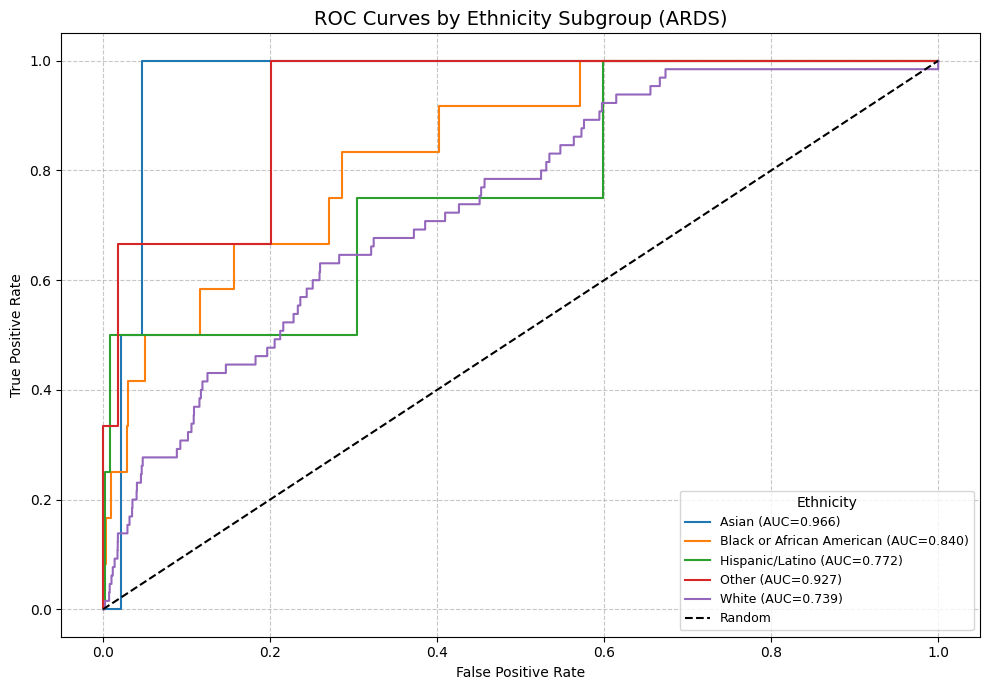

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

ethnicity_groups = fair_df_ethnicity['ethnicity'].unique()

# Plot setup
plt.figure(figsize=(10, 7))

for group in sorted(ethnicity_groups):
    group_df = fair_df_ethnicity[fair_df_ethnicity['ethnicity'] == group]

    fpr, tpr, _ = roc_curve(group_df['y_true'], group_df['y_score'])
    auc = roc_auc_score(group_df['y_true'], group_df['y_score'])

    plt.plot(fpr, tpr, label=f'{group} (AUC={auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.title('ROC Curves by Ethnicity Subgroup (ARDS)', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(title='Ethnicity', loc='lower right', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [26]:
# Define age bins and labels
age_bins = [0, 17, 24, 34, 44, 54, 64, 74, 150]
age_labels = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']

age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)
valid_mask = age_grouped.notna()

y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]
y_score_age = probs[:, 1][valid_mask]
age_grouped_clean = age_grouped[valid_mask]

fair_df_age = pd.DataFrame({
    'y_true': y_test_age,
    'y_pred': y_pred_age,
    'y_score': y_score_age,
    'age_group': age_grouped_clean
})

# Run bootstrapped fairness metric CI
ci_df_age = bootstrap_fairness_metric_ci(
    df=fair_df_age,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='age_group',
    B=1000,
    random_seed=42
)

print("\n=== Logistic Regression Per-Age Group Metrics for ARDS (Mean + 95% CI) ===")
for group in age_labels:
    if group in ci_df_age['Group'].values:
        group_metrics = ci_df_age[ci_df_age['Group'] == group]
        print(f"\nAge Group {group}:")
        for _, row in group_metrics.iterrows():
            metric = row['Metric']
            mean = row['Mean']
            ci_low = row['CI_lower']
            ci_high = row['CI_upper']
            print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local


=== Logistic Regression Per-Age Group Metrics for ARDS (Mean + 95% CI) ===

Age Group 18–24:
accuracy         Mean = 0.95504, CI = (0.95081, 0.95891)
precision        Mean = 0.00230, CI = (0.00000, 0.00728)
recall           Mean = 0.64000, CI = (0.00000, 1.00000)
f1               Mean = 0.00458, CI = (0.00000, 0.01446)
specificity      Mean = 0.95503, CI = (0.95080, 0.95891)
fpr              Mean = 0.04497, CI = (0.04109, 0.04920)
fnr              Mean = nan, CI = (nan, nan)
selection_rate   Mean = 0.04507, CI = (0.04109, 0.04929)
auc              Mean = nan, CI = (nan, nan)

Age Group 25–34:
accuracy         Mean = 0.93126, CI = (0.92697, 0.93535)
precision        Mean = 0.00441, CI = (0.00106, 0.00900)
recall           Mean = 0.66276, CI = (0.20000, 1.00000)
f1               Mean = 0.00874, CI = (0.00210, 0.01782)
specificity      Mean = 0.93139, CI = (0.92705, 0.93551)
fpr              Mean = 0.06861, CI = (0.06449, 0.07295)
fnr              Mean = nan, CI = (nan, nan)
selection_ra

/tmp/ipython-input-27-582225410.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/tmp/ipython-input-27-582225410.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/tmp/ipython-input-27-582225410.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/tmp/ipython-input-27-582225410.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/tmp/ipython-input-27-582225410.py:32: UserWarning: set_tick

ValueError: 'yerr' (shape: (2, 7)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (4,))

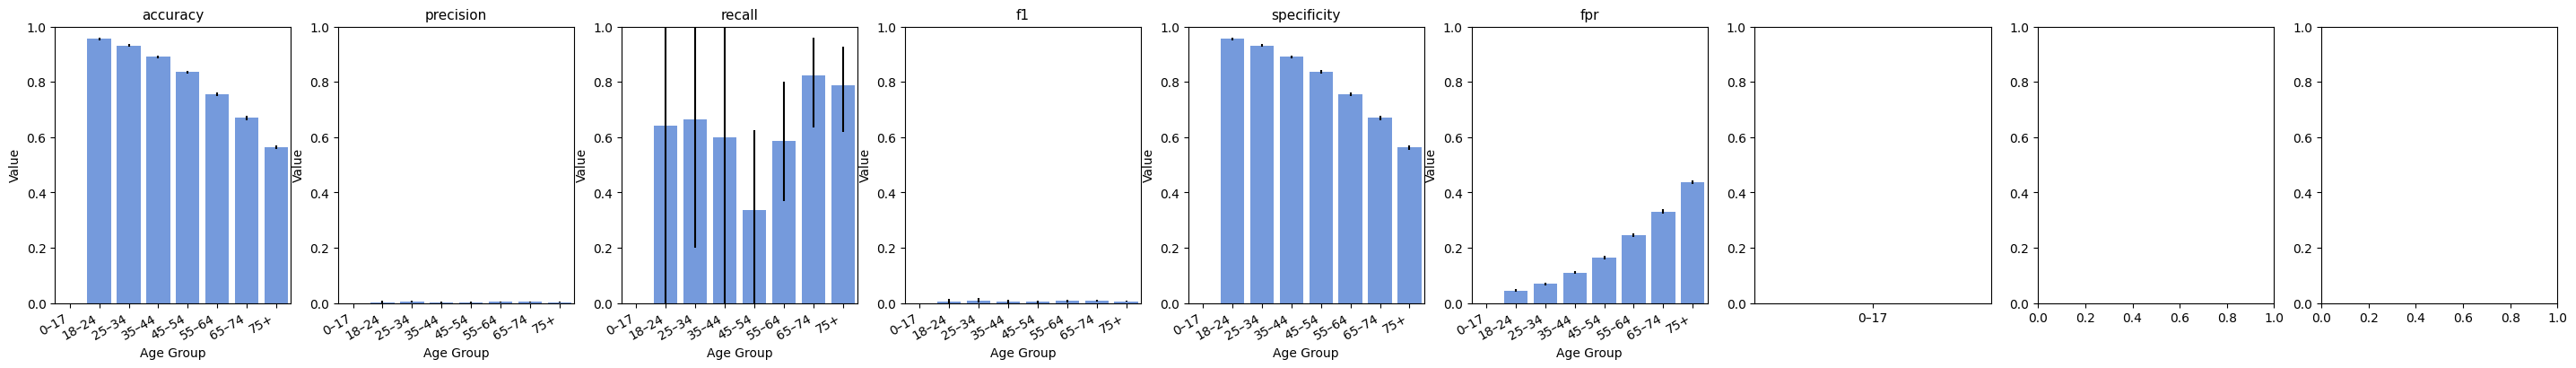

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

ci_df_age['Error Lower'] = ci_df_age['Mean'] - ci_df_age['CI_lower']
ci_df_age['Error Upper'] = ci_df_age['CI_upper'] - ci_df_age['Mean']

age_labels_ordered = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']
ci_df_age['Group'] = pd.Categorical(ci_df_age['Group'], categories=age_labels_ordered, ordered=True)

metrics = ci_df_age['Metric'].unique()
n_metrics = len(metrics)

fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_age[ci_df_age['Metric'] == metric].sort_values(by='Group')

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='cornflowerblue'
    )
    ax.set_title(f'{metric}', fontsize=11)
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Value')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


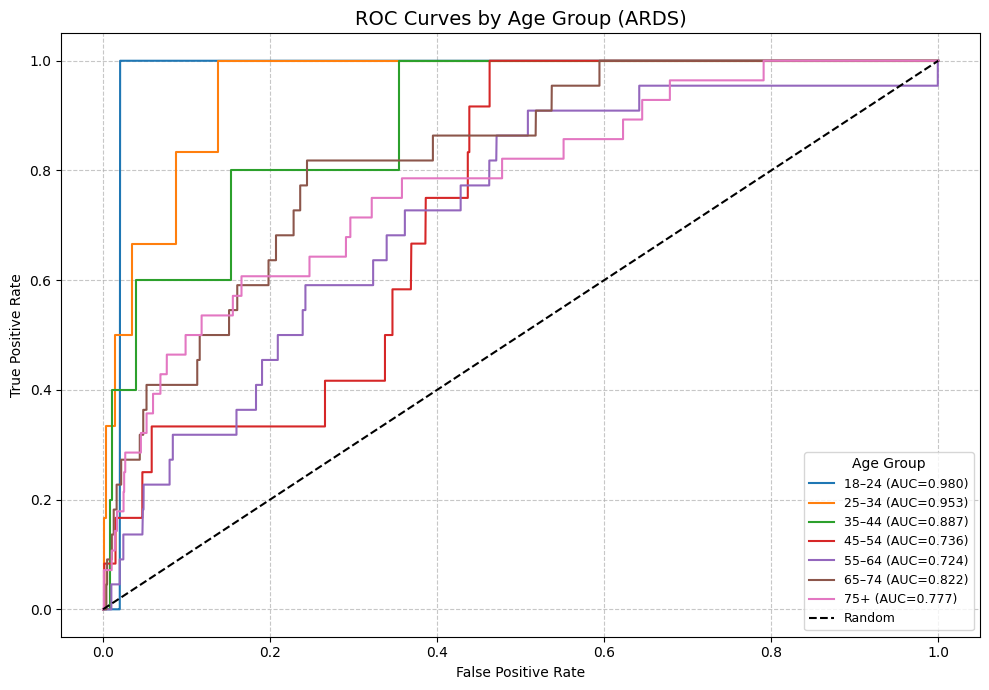

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

age_groups = fair_df_age['age_group'].unique()

plt.figure(figsize=(10, 7))

for group in sorted(age_groups, key=lambda x: age_labels.index(x)):
    group_df = fair_df_age[fair_df_age['age_group'] == group]

    if group_df['y_true'].nunique() < 2:
        print(f"Skipping {group}: only one class present.")
        continue

    fpr, tpr, _ = roc_curve(group_df['y_true'], group_df['y_score'])
    auc = roc_auc_score(group_df['y_true'], group_df['y_score'])

    plt.plot(fpr, tpr, label=f'{group} (AUC={auc:.3f})')

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Plot settings
plt.title('ROC Curves by Age Group (ARDS)', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(title='Age Group', loc='lower right', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [30]:
# Clean and validate insurance data
insurance_raw = df_test['insurance'].astype(str).str.strip()
valid_mask = (
    insurance_raw.notna() &
    (insurance_raw != '') &
    (~insurance_raw.str.lower().isin(['unknown']))
)

y_test_insurance = y_test[valid_mask]
y_pred_insurance = y_pred[valid_mask]
y_score_insurance = probs[:, 1][valid_mask]
insurance_clean = insurance_raw[valid_mask]

insurance_grouped = insurance_clean.str.lower().map({
    'medicaid': 'Medicaid',
    'medicare': 'Medicare'
}).fillna('Other')

fair_df_insurance = pd.DataFrame({
    'y_true': y_test_insurance,
    'y_pred': y_pred_insurance,
    'y_score': y_score_insurance,
    'insurance': insurance_grouped
})

ci_df_insurance = bootstrap_fairness_metric_ci(
    df=fair_df_insurance,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='insurance',
    B=1000,
    random_seed=42
)

print("\n=== Logistic Regression Per-Insurance Type Metrics for ARDS (Mean + 95% CI) ===")
for group in ['Medicaid', 'Medicare', 'Other']:
    if group in ci_df_insurance['Group'].values:
        group_metrics = ci_df_insurance[ci_df_insurance['Group'] == group]
        print(f"\nInsurance: {group}")
        for _, row in group_metrics.iterrows():
            metric = row['Metric']
            mean = row['Mean']
            ci_low = row['CI_lower']
            ci_high = row['CI_upper']
            print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")



=== Logistic Regression Per-Insurance Type Metrics for ARDS (Mean + 95% CI) ===

Insurance: Medicaid
accuracy         Mean = 0.70825, CI = (0.69411, 0.72192)
precision        Mean = 0.00697, CI = (0.00266, 0.01223)
recall           Mean = 0.88495, CI = (0.60000, 1.00000)
f1               Mean = 0.01382, CI = (0.00531, 0.02414)
specificity      Mean = 0.70784, CI = (0.69347, 0.72157)
fpr              Mean = 0.29216, CI = (0.27843, 0.30653)
fnr              Mean = 0.11505, CI = (0.00000, 0.40000)
selection_rate   Mean = 0.29353, CI = (0.27967, 0.30763)
auc              Mean = 0.82987, CI = (0.67557, 0.92716)

Insurance: Medicare
accuracy         Mean = 0.54861, CI = (0.54063, 0.55569)
precision        Mean = 0.00485, CI = (0.00333, 0.00638)
recall           Mean = 0.69776, CI = (0.56604, 0.81481)
f1               Mean = 0.00963, CI = (0.00661, 0.01265)
specificity      Mean = 0.54814, CI = (0.54016, 0.55529)
fpr              Mean = 0.45186, CI = (0.44471, 0.45984)
fnr              Mean 

/tmp/ipython-input-31-1338630268.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/tmp/ipython-input-31-1338630268.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/tmp/ipython-input-31-1338630268.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/tmp/ipython-input-31-1338630268.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
/tmp/ipython-input-31-1338630268.py:32: UserWarning: set

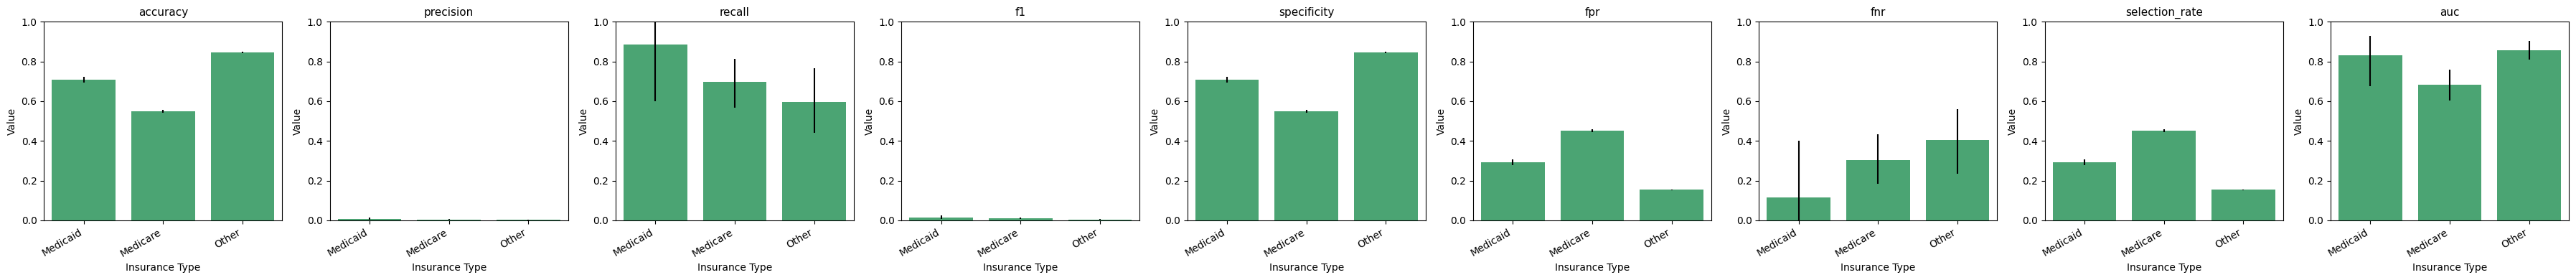

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

ci_df_insurance['Error Lower'] = ci_df_insurance['Mean'] - ci_df_insurance['CI_lower']
ci_df_insurance['Error Upper'] = ci_df_insurance['CI_upper'] - ci_df_insurance['Mean']

insurance_labels_ordered = ['Medicaid', 'Medicare', 'Other']
ci_df_insurance['Group'] = pd.Categorical(ci_df_insurance['Group'], categories=insurance_labels_ordered, ordered=True)

metrics = ci_df_insurance['Metric'].unique()
n_metrics = len(metrics)

fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_insurance[ci_df_insurance['Metric'] == metric].sort_values(by='Group')

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='mediumseagreen'
    )
    ax.set_title(f'{metric}', fontsize=11)
    ax.set_xlabel('Insurance Type')
    ax.set_ylabel('Value')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

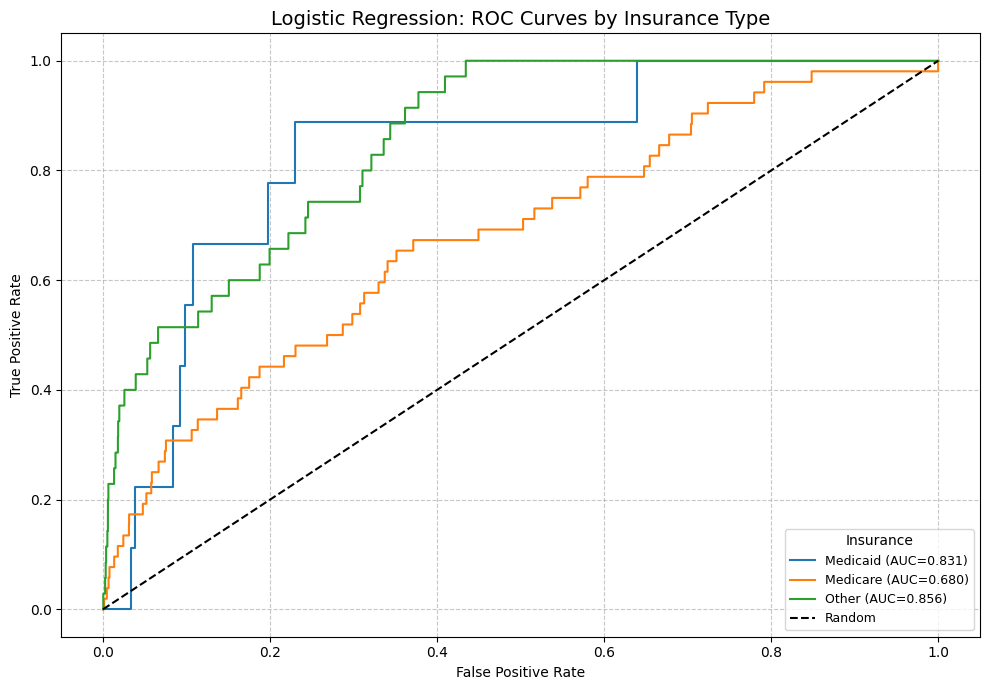

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

insurance_groups = fair_df_insurance['insurance'].unique()
insurance_labels = ['Medicaid', 'Medicare', 'Other']  # for sorting

plt.figure(figsize=(10, 7))

for group in sorted(insurance_groups, key=lambda x: insurance_labels.index(x)):
    group_df = fair_df_insurance[fair_df_insurance['insurance'] == group]

    fpr, tpr, _ = roc_curve(group_df['y_true'], group_df['y_score'])
    auc = roc_auc_score(group_df['y_true'], group_df['y_score'])

    plt.plot(fpr, tpr, label=f'{group} (AUC={auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.title('Logistic Regression: ROC Curves by Insurance Type', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(title='Insurance', loc='lower right', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Logistic Regression (with standardization + SMOTE):
AUC: 0.6647790270265246
AUPRC: 0.004776904699060918
Sensitivity: 0.6145833333333334
Specificity: 0.720738303685942
Score thresold: 0.2986040885177163
2.5 97.5


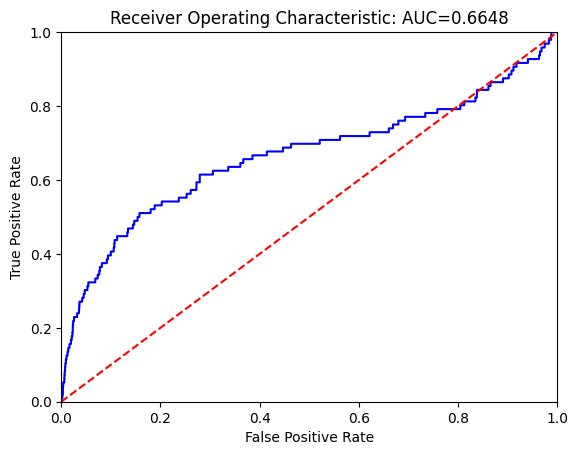

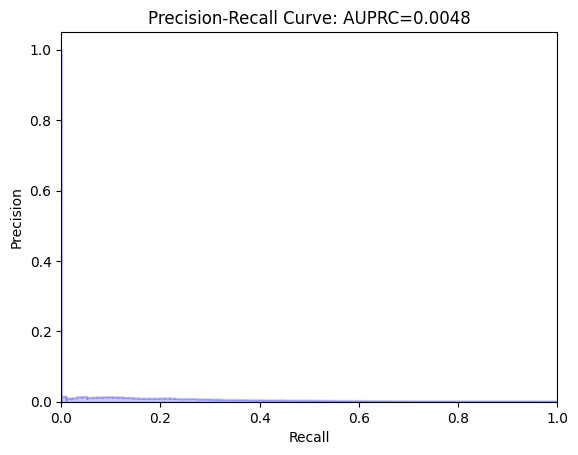

Accuracy: 0.720958991098584


In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import pickle
import time

# Step 1: Define variables to standardize
vars_to_standardize = [
    "age", "n_ed_30d", "n_ed_90d", "n_ed_365d",
    "n_hosp_30d", "n_hosp_90d", "n_hosp_365d",
    "n_icu_30d", "n_icu_90d", "n_icu_365d",
    "triage_temperature", "triage_heartrate",
    "triage_resprate", "triage_o2sat",
    "triage_sbp", "triage_dbp", "triage_pain"
]

# Step 2: Standardize training and test set
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[vars_to_standardize] = scaler.fit_transform(X_train[vars_to_standardize])
X_test_scaled[vars_to_standardize] = scaler.transform(X_test[vars_to_standardize])

# Step 3: Apply SMOTE on the training set
smote = SMOTE(random_state=random_seed)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Step 4: Train the logistic regression model
print("Logistic Regression (with standardization + SMOTE):")
logreg = LogisticRegression(random_state=random_seed, max_iter=1000)
start = time.time()
logreg.fit(X_resampled, y_resampled)
runtime = time.time() - start

# Step 5: Save the model
with open('smote_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)

# Step 6: Make predictions + evaluate
probs = logreg.predict_proba(X_test_scaled)
y_pred = (probs[:, 1] >= 0.299).astype(int)

result = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed)

# Accuracy
acc = accuracy_score(y_test, y_pred)

results = ["LR"]
results.extend(result)
results.append(runtime)
results.append(acc)

print("Accuracy:", acc)


In [50]:
result_list = [results]

result_df = pd.DataFrame(result_list, columns=[
    'Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold',
    'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap',
    'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity',
    'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime', 'accuracy'
])

result_df = result_df.round(3)

formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df['Accuracy'] = result_df['accuracy']

formatted_result_df


,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime,Accuracy
0,LR,0.299,0.665 (0.605-0.73),0.005 (0.003-0.009),0.615 (0.568-0.736),0.721 (0.694-0.817),45.196,0.085


In [53]:
# Clean gender variable
gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

# Apply mask to target and predictions
y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
y_score_gender = probs[:, 1][valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

# Create dataframe for bootstrap function
fair_df = pd.DataFrame({
    'y_true': y_test_gender,
    'y_pred': y_pred_gender,
    'y_score': y_score_gender,
    'gender': gender_grouped
})

# Run bootstrapped fairness metric CI
ci_df_gender = bootstrap_fairness_metric_ci(
    df=fair_df,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='gender',
    B=1000,
    random_seed=42
)

# Print formatted output
print("\n=== Logistic Regression + SMOTE Per-Gender Metrics for ARDS (Mean + 95% CI) ===")
for group in ['Female', 'Male']:
    group_id = 0 if group == 'Female' else 1
    group_metrics = ci_df_gender[ci_df_gender['Group'] == group_id]
    print(f"\n{group}:")
    for _, row in group_metrics.iterrows():
        metric = row['Metric']
        mean = row['Mean']
        ci_low = row['CI_lower']
        ci_high = row['CI_upper']
        print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")


=== Logistic Regression + SMOTE Per-Gender Metrics for ARDS (Mean + 95% CI) ===

Female:
accuracy         Mean = 0.71445, CI = (0.71022, 0.71802)
precision        Mean = 0.00210, CI = (0.00137, 0.00289)
recall           Mean = 0.63216, CI = (0.48836, 0.76474)
f1               Mean = 0.00418, CI = (0.00273, 0.00575)
specificity      Mean = 0.71453, CI = (0.71038, 0.71809)
fpr              Mean = 0.28547, CI = (0.28191, 0.28962)
fnr              Mean = 0.36784, CI = (0.23526, 0.51164)
selection_rate   Mean = 0.28580, CI = (0.28224, 0.28988)
auc              Mean = 0.71471, CI = (0.62055, 0.80571)

Male:
accuracy         Mean = 0.72883, CI = (0.72430, 0.73314)
precision        Mean = 0.00251, CI = (0.00167, 0.00346)
recall           Mean = 0.56036, CI = (0.41377, 0.69646)
f1               Mean = 0.00501, CI = (0.00333, 0.00688)
specificity      Mean = 0.72904, CI = (0.72453, 0.73330)
fpr              Mean = 0.27096, CI = (0.26670, 0.27547)
fnr              Mean = 0.43964, CI = (0.30354, 

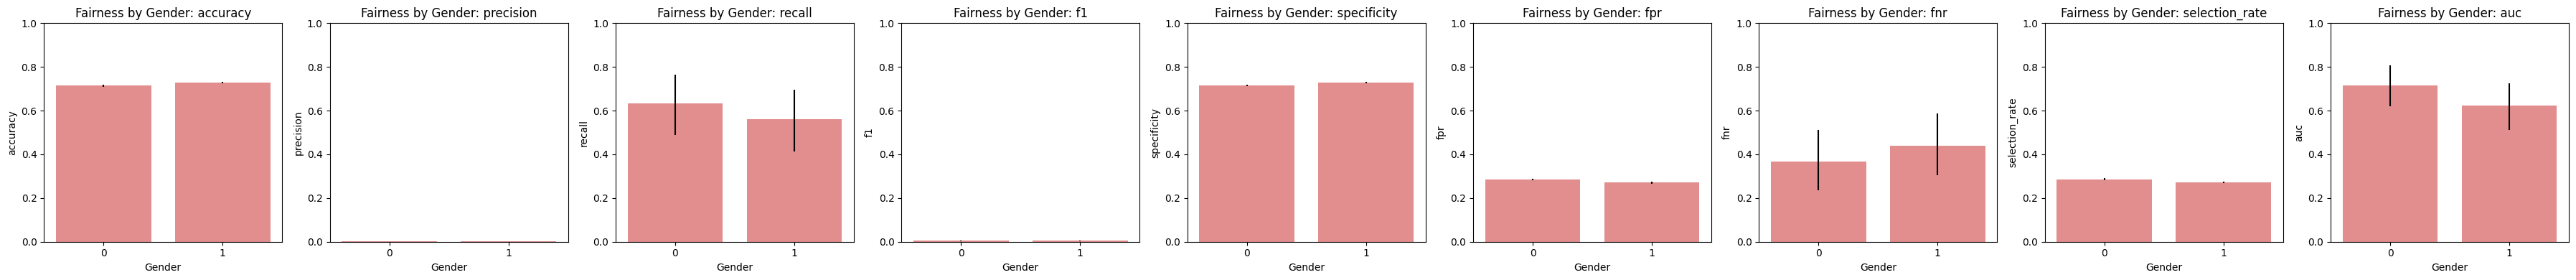

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

ci_df_gender['Error Lower'] = ci_df_gender['Mean'] - ci_df_gender['CI_lower']
ci_df_gender['Error Upper'] = ci_df_gender['CI_upper'] - ci_df_gender['Mean']

metrics = ci_df_gender['Metric'].unique()
n_metrics = len(metrics)

# Plot setup
fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_gender[ci_df_gender['Metric'] == metric]

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='lightcoral'
    )
    ax.set_title(f'Fairness by Gender: {metric}')
    ax.set_xlabel('Gender')
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

/tmp/ipython-input-55-835293240.py:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linestyle='--')


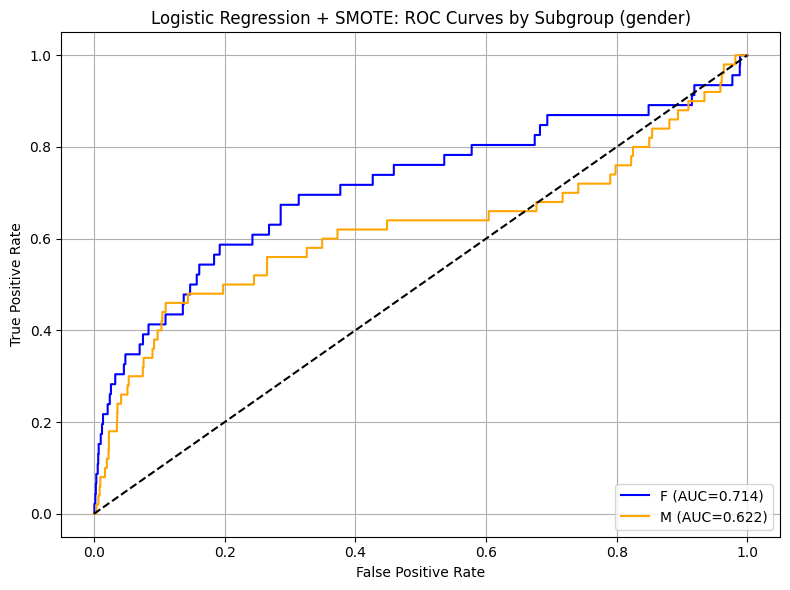

In [55]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Split by gender
female_df = fair_df[fair_df['gender'] == 0]  # Female
male_df = fair_df[fair_df['gender'] == 1]    # Male

# Calculate ROC curve points and AUC
fpr_f, tpr_f, _ = roc_curve(female_df['y_true'], female_df['y_score'])
auc_f = roc_auc_score(female_df['y_true'], female_df['y_score'])

fpr_m, tpr_m, _ = roc_curve(male_df['y_true'], male_df['y_score'])
auc_m = roc_auc_score(male_df['y_true'], male_df['y_score'])

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_f, tpr_f, label=f'F (AUC={auc_f:.3f})', color='blue')
plt.plot(fpr_m, tpr_m, label=f'M (AUC={auc_m:.3f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', linestyle='--')

plt.title('Logistic Regression + SMOTE: ROC Curves by Subgroup (gender)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()